## Demo PyHeat Youri & Mathis

Ceci est une notebook de démo pour la lib pyheat.
C'est une version temporaire

Toutes les valeurs utilisées dans ce notebook sont totalement arbitraires.
L'objectif n'est pas de montrer des résultats mais le fonctionnement de la lib et ses entrées/sorties.

In [2]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

In [5]:
# read in our data
capteur_riviere = pd.read_csv("data/Point034/point034_P_measures.csv", sep = ',', header = 0, names = ['dates', 'tension', 'temperature_riviere'], usecols = [1, 2, 3], skiprows=1)
capteur_ZH = pd.read_csv("data/Point034/point034_T_measures.csv", sep = ',', header = 0, names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], usecols = [1, 2, 3, 4, 5], skiprows=1)
etalonage_capteur_riv = pd.read_csv("configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# mise en forme de la date
capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'], infer_datetime_format=True)
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True)

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

In [6]:
capteur_ZH.head()

,dates,temperature_10,temperature_20,temperature_30,temperature_40
0,2016-06-27 12:00:00,286.960,286.984,287.008,286.960
1,2016-06-27 12:15:00,286.984,287.008,287.032,286.984
2,2016-06-27 12:30:00,287.080,287.104,287.200,287.152
3,2016-06-27 12:45:00,287.032,287.104,287.176,287.104
4,2016-06-27 13:00:00,287.008,287.080,287.176,287.104


In [7]:


col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .05,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [8]:
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [9]:
#Peut définir un tuple avec la class Param (NamedTuple)
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

#Ou en tuple plus classiquement
params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

In [10]:
col.compute_solve_transi(params, 100)

temps = col.temps_solve

col.compute_solve_transi(params_tuple, 100)

temps_from_tuple = col.temps_solve

assert np.array_equal(temps, temps_from_tuple)

--- Compute Solve Transi ---
Parametres(moinslog10K=4, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Done.
--- Compute Solve Transi ---
Parametres(moinslog10K=4, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Done.


AssertionError: 

In [13]:
temps

array([[291.3441 , 287.50143, 286.6134 , ...,       nan,       nan,
              nan],
       [291.058  , 288.18478, 286.79037, ...,       nan,       nan,
              nan],
       [290.78473, 288.63757, 287.0357 , ...,       nan,       nan,
              nan],
       ...,
       [286.1446 , 286.1045 , 286.23962, ...,       nan,       nan,
              nan],
       [286.07278, 286.05344, 286.2018 , ...,       nan,       nan,
              nan],
       [285.99826, 286.0061 , 286.1674 , ...,       nan,       nan,
              nan]], dtype=float32)

In [16]:
temps_from_tuple - temps

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]], dtype=float32)

285.84055

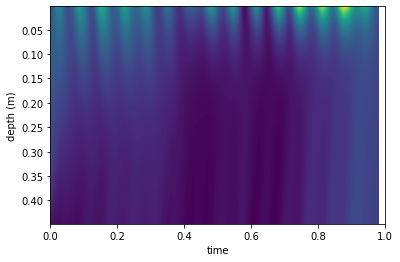

In [11]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
np.nanmin(col.temps_solve[:,:-5])

ValueError: operands could not be broadcast together with shapes (1438,) (1460,) 

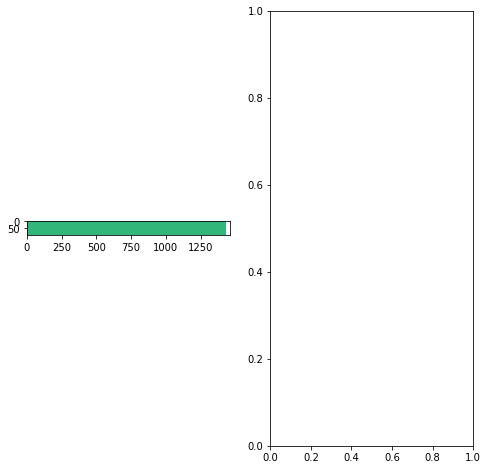

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8,8), facecolor = 'w')
axs[0].imshow(col.advec_flows_solve)
axs[1].imshow(col.conduc_flows_solve)

In [ ]:
from itertools import islice

fig, axs = plt.subplots(1, 2, figsize=(8,4),facecolor = 'w')

ite = zip(
    col.temps_solve.T,
    col.times_solve
)
for temps, t in islice(ite, 20, None, 20):
    axs[0].plot(
        col.depths_solve,
        temps,
        label = f"{t:.1e}"
    )
axs[1].plot(
    col.times_solve,
    col.flows_solve.T,
    label = f"{t:.1e}"
)

axs[0].set_xlabel("depth (m)")
axs[0].set_ylabel("temperature (K)")
#axs[1].legend()

In [ ]:
ind = 23
print(f"Index {ind} in z_array -> {col.depths_solve[ind]}")
print(f"Temp at index {ind} and t = 0 -> {col.temps_solve[0, ind]:.3f}")
print(f"Temp at {col.depths_solve[ind]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind])[0]:.3f}")
print("col.get_temps correct inaccuracy in z.")
print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0]), label = f"depth={col.depths_solve[0]:.3f}")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind]), label = f"depth={col.depths_solve[ind]:.3f}")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
ax.legend()
#TODO : Faire la meme avec le temps en paramètre

In [ ]:
priors = {
    "moinslog10K": ((1.5, 6), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 5), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

col.compute_mcmc(
    nb_iter = 200,
    priors = priors,
    nb_cells = 100,
    quantile = (.05, .5, .95)
)

In [ ]:
print("Normal si les resultats ont pas de sens")

fig, axes = plt.subplots(1, 4, figsize = (9,4), facecolor = 'w')

ite = zip(
    ["moinslog10K", "n", "lambda_s", "rhos_cs"],
    [col.all_moinslog10K, col.all_n, col.all_lambda_s, col.all_rhos_cs] 
)

for (lbl, vals), ax in zip(ite, axes):
    ax.hist(vals, bins = 20)
    ax.set_title(lbl)
#col.get_all_n() et ses dérivés sont aussi dispo sous forme de méthodes

In [ ]:
fig, axs = plt.subplots(1,2,facecolor = 'w')
axs[0].plot(col.all_energy)
axs[1].plot(col.all_acceptance_ratio)

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("energy")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("acceptance")

In [ ]:
#Can also sample param from mcmc trajectory
sampled_params = col.get_best_param()
print(sampled_params)

col.compute_solve_transi(sampled_params, 41)

fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1]
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

In [ ]:
fig, ax = plt.subplots(facecolor = 'w')

#Pas encore possible de donner le temps encore.
for quant in (.05,.5,.95):
    ax.plot(
        col.times_mcmc,
        col.get_temps_quantile(quant)[20, :],
        label = quant
    )
    
ax.legend()